In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import numpy as np
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.data.NETWORKS import NAMED_CONNECTIONS
from abcd.data.SELF_REPORTED import MH_SCORES
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.analysis.methods.sklearn_cca import fit_cca
from abcd.plotting.seaborn.scatter import plot_scatter
from abcd.plotting.seaborn.correlations import plot_correlations
from abcd.plotting.matplotlib.cca_plot import plot_cca_rotations

In [3]:
k = 5
subjects_df, events_df = get_subjects_events()
splits = save_restore_sex_fmri_splits(k=k)
print("There are {} events for {} subjects".format(len(events_df), len(subjects_df)))

There are 19605 events for 9879 subjects


In [4]:
# Prepare the data
mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
events_df = add_event_vars(events_df, mental_health_file, vars=list(MH_SCORES.keys()))
print("From those, there are {} events with mental health scores".format(len(events_df)))

# Remove missing values
events_df = events_df.dropna()
print("After removing missing values, the df has {} events".format(len(events_df)))

# Normalize funcional connectivity and mental helth scores in the (0, 1) range
for var_id in MH_SCORES.keys():
    events_df = normalize_var(events_df, var_id, var_id)
for var_id in NAMED_CONNECTIONS.keys():
    events_df = normalize_var(events_df, var_id, var_id)
    
# Rename columns
events_df = events_df.rename(columns=MH_SCORES)
events_df = events_df.rename(columns=NAMED_CONNECTIONS)

c:\users\camgonza\desktop\abcd5\abcd\utils\io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


From those, there are 19573 events with mental health scores
After removing missing values, the df has 18370 events


In [6]:
feature_columns = list(NAMED_CONNECTIONS.values())
target_columns = list(MH_SCORES.values())
nr_components = 3
cca_model, events_df = fit_cca(events_df, feature_columns, target_columns, nr_components=nr_components)
cc_x_cols, cc_y_cols = ["CC{}_X".format(dim+1) for dim in range(nr_components)], ["CC{}_Y".format(dim+1) for dim in range(nr_components)]

Covariate on dimension 1 has correlation 0.19
Covariate on dimension 2 has correlation 0.16
Covariate on dimension 3 has correlation 0.13


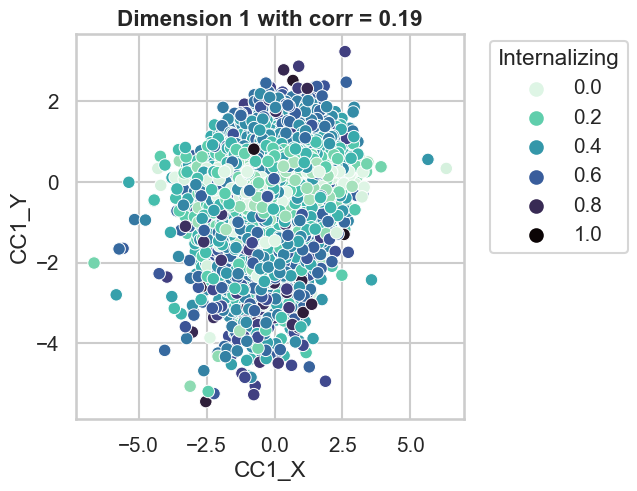

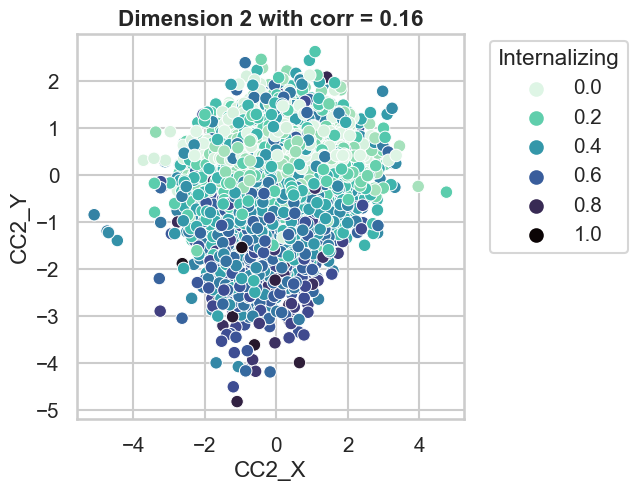

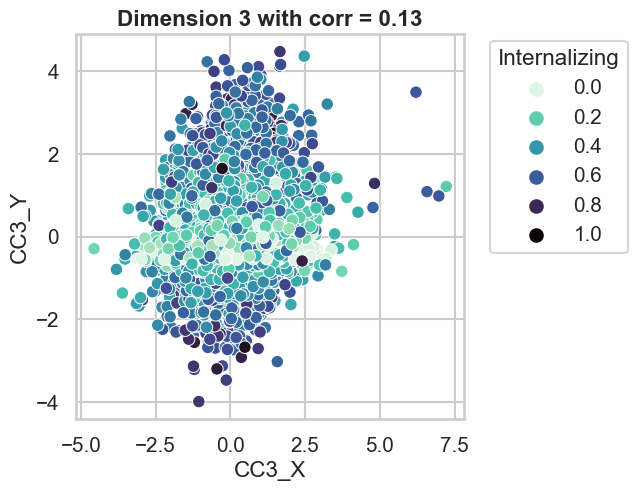

In [9]:
# Plot correlations

hue_col = 'Internalizing'
for dim in range(nr_components):
    x_col, y_col = "CC{0}_X".format(dim+1), "CC{0}_Y".format(dim+1)
    title = "Dimension {0} with corr = {1:.2f}".format(dim+1, np.corrcoef(events_df["CC{0}_X".format(dim+1)], events_df["CC{}_Y".format(dim+1)])[0][1])
    plot_scatter(events_df, x_col, y_col, hue_col, title)

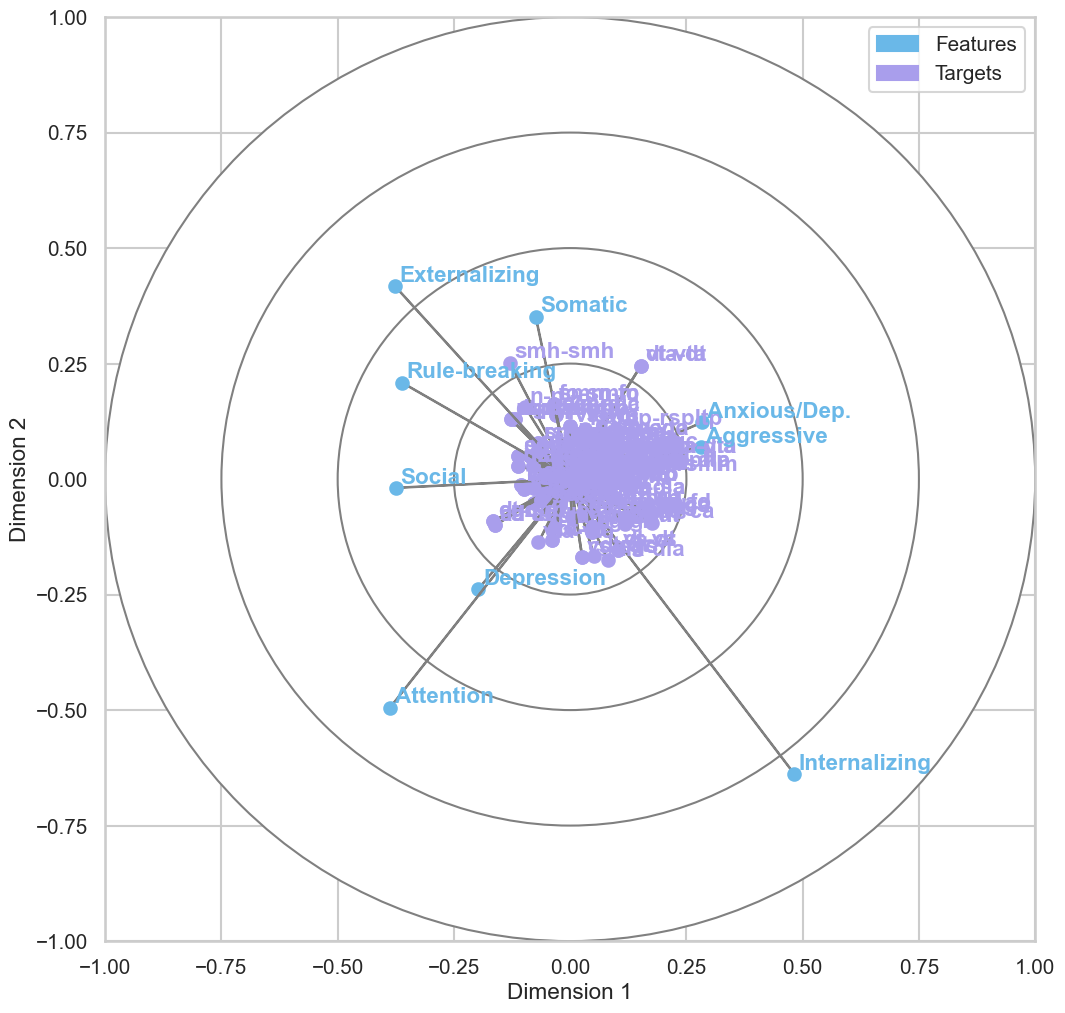

In [34]:
plot = plot_cca_rotations(cca_model, x_vars=feature_columns, y_vars=target_columns, x_component=0, y_component=1)
plot.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

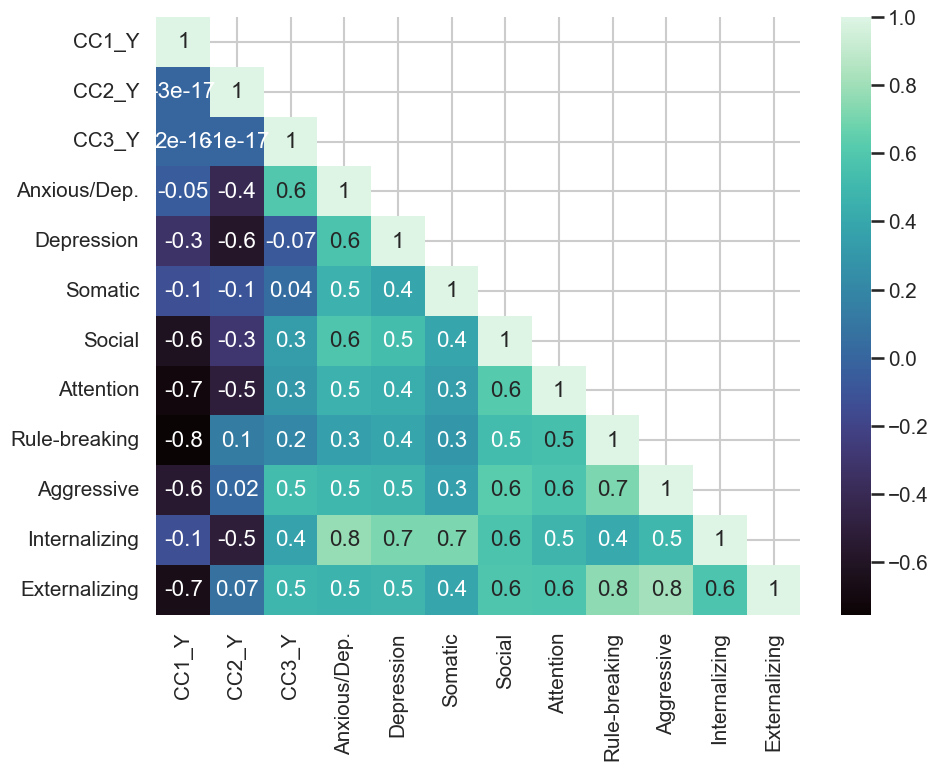

In [11]:
plot_correlations(events_df, columns=cc_y_cols + target_columns)

In [12]:
# Select only the k variables with higher correlation
columns = cc_x_cols + cc_y_cols + feature_columns + target_columns
corr_df = events_df[columns].copy()
corr_matrix = corr_df.corr(method='pearson') 

                      CC1_X         CC2_X         CC3_X         CC1_Y  \
CC1_X          1.000000e+00  2.894187e-16 -9.376283e-17  1.941070e-01   
CC2_X          2.894187e-16  1.000000e+00  3.141175e-16 -9.219003e-05   
CC3_X         -9.376283e-17  3.141175e-16  1.000000e+00  1.219894e-07   
CC1_Y          1.941070e-01 -9.219003e-05  1.219894e-07  1.000000e+00   
CC2_Y         -4.182200e-16  1.572871e-01  1.088924e-04 -2.686065e-17   
...                     ...           ...           ...           ...   
Attention     -1.386422e-01 -7.893337e-02  4.137685e-02 -7.142564e-01   
Rule-breaking -1.462975e-01  2.062537e-02  2.762947e-02 -7.536950e-01   
Aggressive    -1.070141e-01  2.918409e-03  7.088354e-02 -5.513150e-01   
Internalizing -2.582438e-02 -7.993003e-02  4.891849e-02 -1.330420e-01   
Externalizing -1.287934e-01  1.078195e-02  6.641374e-02 -6.635177e-01   

                      CC2_Y         CC3_Y     ad-ad    ad-cgc     ad-ca  \
CC1_X         -4.182200e-16  1.332397e-15  0.082

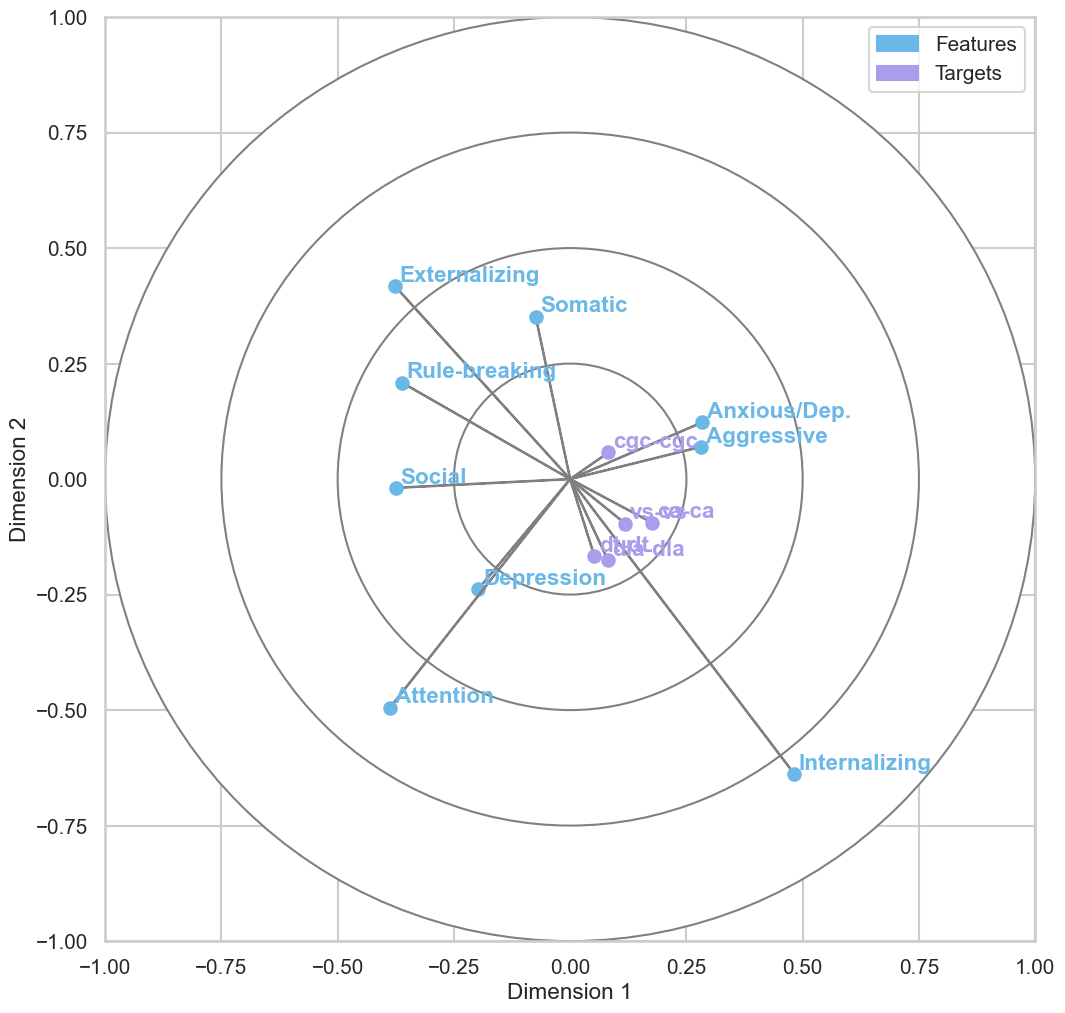

In [52]:
# For each dimension, select a subset of feature columns and target columns with highest correlation
nr_feature_cols = 5
nr_target_cols = 9
dimension_corrs = corr_matrix.to_dict()

dim = 0
feature_corrs = sorted([(v, k) for k, v in dimension_corrs["CC{}_X".format(dim+1)].items() if k in feature_columns], reverse=True)[:nr_feature_cols]
target_corrs = sorted([(v, k) for k, v in dimension_corrs["CC{}_Y".format(dim+1)].items() if k in target_columns], reverse=True)[:nr_target_cols]
features_subset, targets_subset = [x[1] for x in feature_corrs],  [x[1] for x in target_corrs]
plot = plot_cca_rotations(cca_model, x_vars=feature_columns, y_vars=target_columns, x_component=0, y_component=1, include_vars=features_subset+targets_subset)
plot.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

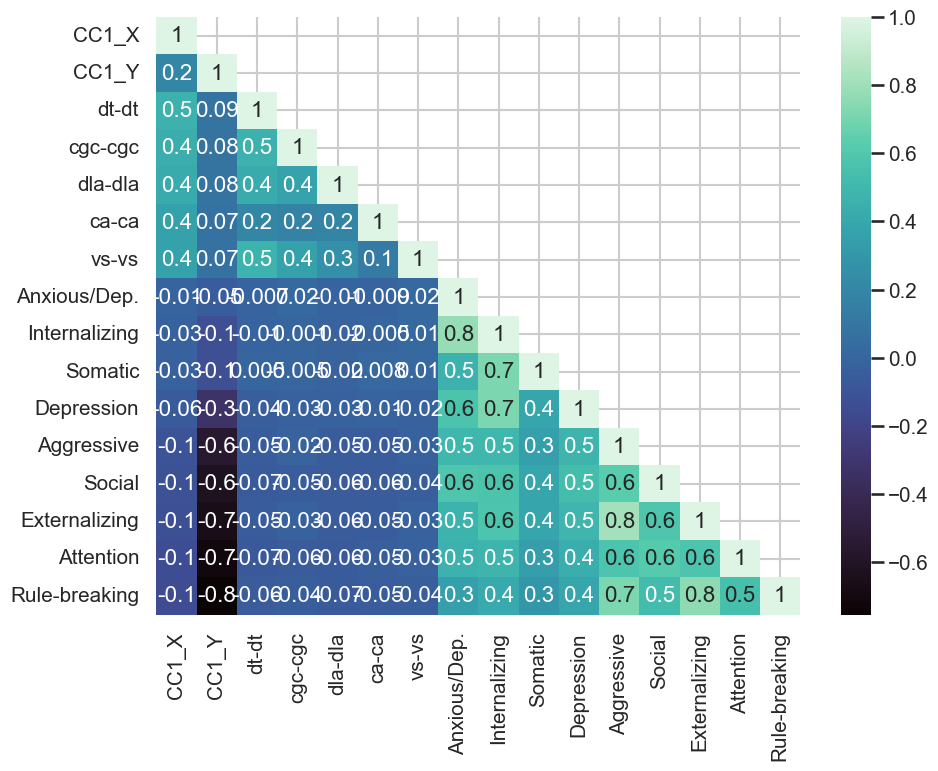

In [54]:
plot_correlations(events_df, columns=["CC{}_X".format(dim+1), "CC{}_Y".format(dim+1)]+features_subset+targets_subset)